## 1. Introduction

The zip file is training data is pulled from raw logs. 

It has three columns that record user activity over time:
user_id: A hash that uniquely identifies the user.
activity_date: The date of the activity
activity_type: The type of activity

Our goal is to predict which users have a high chance of a FUTURE purchase given the user's PAST activities.

Using the training data, build a model that predicts which user_id's will make a purchase in the future.
Score the test data with the model you've created and sort the top 1,000 user_id's from most to least likely to purchase.

Please submit the following:
* Answers to the following questions:
	1. How did you approach the time-based aspect of the problem?
	2. Describe which activity types you believe are most useful in predicting which user will purchase in the future.
	3. If you had more time, what else would you do?
* Provide a file (csv, tsv, or similar) containing the top 1,000 user_id's most likely to convert.
* Your code that you used to generate your answers

We will be evaluating your submission on the following criteria:
1. EDA
2. Feature engineering
3. Model building
4. Model performance
5. Answers to the questions

## 2. Data Load

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/content/training.tsv',delimiter="\t",header=None)

### 2.1 Data Inspection

In [4]:
df.shape

(2187630, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2187630 entries, 0 to 2187629
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   0       object
 1   1       object
 2   2       object
dtypes: object(3)
memory usage: 50.1+ MB


In [6]:
df.describe()

,0,1,2
count,2187630,2187630,2187630
unique,142412,671,8
top,2cd311cc3ef2d0c,2014-06-18,EmailOpen
freq,2718,22388,1414569


In [7]:
df.columns = ['UID','Date','Activity']
df.head(20)

,UID,Date,Activity
0,00002acbe042d69,2013-07-11,EmailOpen
1,00002acbe042d69,2013-07-11,FormSubmit
2,00002acbe042d69,2013-07-15,EmailOpen
3,00002acbe042d69,2013-07-17,EmailOpen
4,00002acbe042d69,2013-07-18,EmailOpen
5,00002acbe042d69,2013-07-25,EmailOpen
6,00002acbe042d69,2013-07-26,EmailOpen
7,00002acbe042d69,2013-08-01,EmailOpen
8,00002acbe042d69,2013-08-05,EmailOpen
9,00002acbe042d69,2013-08-12,EmailOpen


In [159]:
len(df.UID.unique())

210973

### 2.2 Data Processing

In [160]:
df_activity = df.Activity.value_counts().to_frame('Counts')
df_activity

,Counts
EmailOpen,2051729
Purchase,252927
WebVisit,250425
PageView,249373
EmailClickthrough,185763
FormSubmit,114315
CustomerSupport,64504
CustomerSup,1


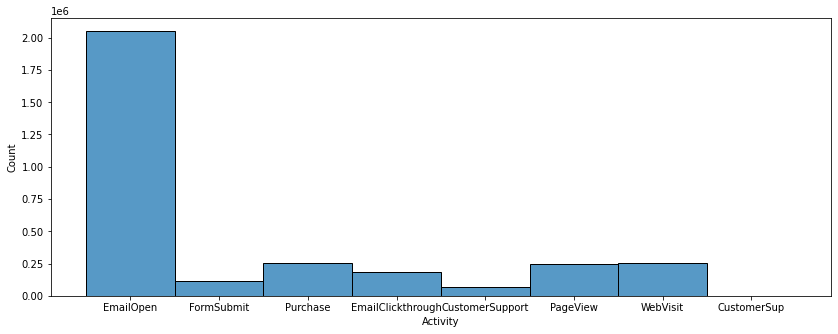

In [161]:
plt.figure(figsize=(12,5))
sns.histplot(data=df,x='Activity')
plt.tight_layout(2.0)
plt.show()

In [162]:
df_cust = df.UID.value_counts().to_frame('Counts')
df_cust.head()

,Counts
2cd311cc3ef2d0c,2718
701166975141892,2086
0ec78db2c7be600,1968
01e3f460ec72931,1965
6b784cb0569218a,1828


### 2.4 Feature Engineering

In [163]:
df['Date'] = pd.to_datetime(df['Date']) 

In [164]:
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [165]:
df.head(2)

,UID,Date,Activity,Day,Month,Year
0,00002acbe042d69,2013-07-11,EmailOpen,11,7,2013
1,00002acbe042d69,2013-07-11,FormSubmit,11,7,2013


In [166]:
#Binning the Age column
cut_labels = ['W1', 'W2', 'W3', 'W4']
cut_bins = [0,7,14,21,31]
df['Week'] = pd.cut(df['Day'], bins=cut_bins, labels=cut_labels)
df['Week'].value_counts()

W4    1161713
W2     674222
W1     669858
W3     663244
Name: Week, dtype: int64

In [167]:
#Binning the Age column
cut_labels = ['Q1', 'Q2', 'Q3', 'Q4']
cut_bins = [0,3,6,9,12]
df['Quarter'] = pd.cut(df['Month'], bins=cut_bins, labels=cut_labels)
df['Quarter'].value_counts()

Q1    981088
Q4    812483
Q3    727496
Q2    647970
Name: Quarter, dtype: int64

In [168]:
df.head()

,UID,Date,Activity,Day,Month,Year,Week,Quarter
0,00002acbe042d69,2013-07-11,EmailOpen,11,7,2013,W2,Q3
1,00002acbe042d69,2013-07-11,FormSubmit,11,7,2013,W2,Q3
2,00002acbe042d69,2013-07-15,EmailOpen,15,7,2013,W3,Q3
3,00002acbe042d69,2013-07-17,EmailOpen,17,7,2013,W3,Q3
4,00002acbe042d69,2013-07-18,EmailOpen,18,7,2013,W3,Q3


In [169]:
df.isna().sum()

UID         0
Date        0
Activity    0
Day         0
Month       0
Year        0
Week        0
Quarter     0
dtype: int64

In [170]:
#df['Purchase'] = df['Activity']

In [171]:
#df['Purchase'] = df['Activity'].map({'Purchase':1,'EmailOpen':0,'WebVisit':0,'PageView':0,'EmailClickthrough':0,'FormSubmit':0,'CustomerSupport':0,'CustomerSup':0})

In [8]:
df[df.loc[:,'Activity']=='Purchase']

,UID,Date,Activity
30,0000ecf58c94668,2013-10-30,Purchase
31,0000ecf58c94668,2013-11-08,Purchase
32,0000ecf58c94668,2013-12-06,Purchase
36,0000ecf58c94668,2014-04-16,Purchase
37,0000ecf58c94668,2014-05-15,Purchase
...,...,...,...
2187612,6267e5ec1e4cdf9,2014-10-30,Purchase
2187614,6267e5ec1e4cdf9,2014-10-31,Purchase
2187616,6267e5ec1e4cdf9,2014-11-05,Purchase
2187617,6267e5ec1e4cdf9,2014-11-06,Purchase


In [10]:
df[df.loc[:,'UID']=='0000ecf58c94668'].sort_values(by='Date')

,UID,Date,Activity
30,0000ecf58c94668,2013-10-30,Purchase
31,0000ecf58c94668,2013-11-08,Purchase
32,0000ecf58c94668,2013-12-06,Purchase
33,0000ecf58c94668,2014-02-24,EmailClickthrough
34,0000ecf58c94668,2014-02-24,FormSubmit
35,0000ecf58c94668,2014-03-04,EmailOpen
36,0000ecf58c94668,2014-04-16,Purchase
37,0000ecf58c94668,2014-05-15,Purchase
38,0000ecf58c94668,2014-06-21,EmailOpen
39,0000ecf58c94668,2014-07-01,EmailOpen


In [173]:
df['Year'].value_counts()

2014    1730993
2015     731678
2013     706366
Name: Year, dtype: int64

In [174]:
df['Year'] = df['Year'].map({2014:'Year_2014',2013:'Year_2013',2015:'Year_2015'})

In [175]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [176]:
ohe_cols = ['Activity','Week','Quarter','Year']

df_ohe  = pd.get_dummies(df[ohe_cols],drop_first=True)

In [177]:
df_ohe 

,Activity_CustomerSupport,Activity_EmailClickthrough,Activity_EmailOpen,Activity_FormSubmit,Activity_PageView,Activity_Purchase,Activity_WebVisit,Week_W2,Week_W3,Week_W4,Quarter_Q2,Quarter_Q3,Quarter_Q4,Year_Year_2014,Year_Year_2015
0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169032,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
3169033,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3169034,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
3169035,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0


In [178]:
cols_drop = ['UID','Date','Activity','Week','Quarter','Year']
UID_data = df['UID']

In [179]:
le = LabelEncoder()

#df['Year'] = le.fit_transform(df['Year'])

In [180]:
#f['Year'].value_counts()

In [181]:
df_final = pd.concat([df,df_ohe],axis=1)

In [182]:
df_final.head(3)

,UID,Date,Activity,Day,Month,Year,Week,Quarter,Activity_CustomerSupport,Activity_EmailClickthrough,Activity_EmailOpen,Activity_FormSubmit,Activity_PageView,Activity_Purchase,Activity_WebVisit,Week_W2,Week_W3,Week_W4,Quarter_Q2,Quarter_Q3,Quarter_Q4,Year_Year_2014,Year_Year_2015
0,00002acbe042d69,2013-07-11,EmailOpen,11,7,Year_2013,W2,Q3,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
1,00002acbe042d69,2013-07-11,FormSubmit,11,7,Year_2013,W2,Q3,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
2,00002acbe042d69,2013-07-15,EmailOpen,15,7,Year_2013,W3,Q3,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0


In [183]:
df_train = df_final.drop(labels=cols_drop,axis=1)

### 2.5 Feature Scaling

In [184]:
scaler = StandardScaler()

cols = ['Day', 'Month']

df_train[cols] = scaler.fit_transform(df_train[cols])

In [185]:
df_train.head(3)

,Day,Month,Activity_CustomerSupport,Activity_EmailClickthrough,Activity_EmailOpen,Activity_FormSubmit,Activity_PageView,Activity_Purchase,Activity_WebVisit,Week_W2,Week_W3,Week_W4,Quarter_Q2,Quarter_Q3,Quarter_Q4,Year_Year_2014,Year_Year_2015
0,-0.624956,0.214846,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
1,-0.624956,0.214846,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
2,-0.183728,0.214846,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0


### 2.6 Data Analysis

In [186]:
df_train.head()

,Day,Month,Activity_CustomerSupport,Activity_EmailClickthrough,Activity_EmailOpen,Activity_FormSubmit,Activity_PageView,Activity_Purchase,Activity_WebVisit,Week_W2,Week_W3,Week_W4,Quarter_Q2,Quarter_Q3,Quarter_Q4,Year_Year_2014,Year_Year_2015
0,-0.624956,0.214846,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
1,-0.624956,0.214846,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
2,-0.183728,0.214846,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
3,0.036886,0.214846,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
4,0.147193,0.214846,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0


In [187]:
df_train['Activity_Purchase'].value_counts()

0    2916110
1     252927
Name: Activity_Purchase, dtype: int64

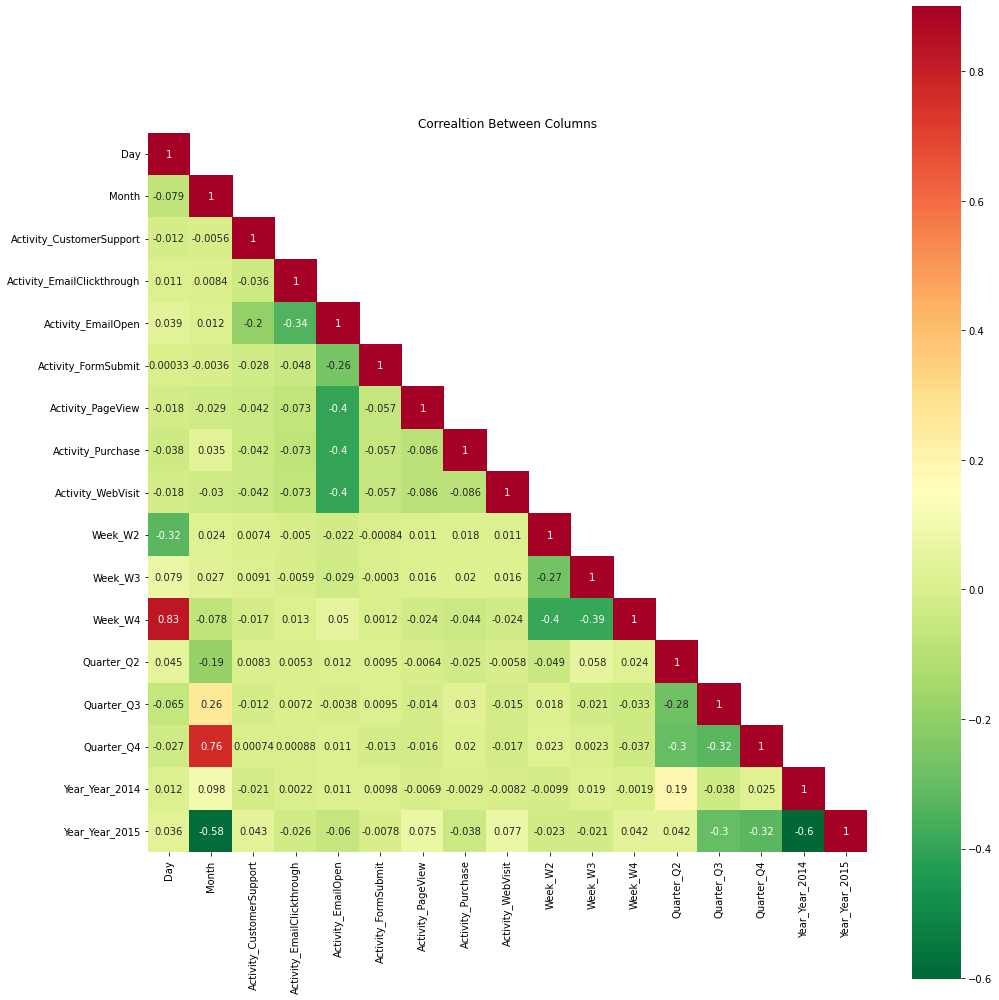

In [188]:
#Firstly, creating the correlation matrix
corr_mat = df_train.corr()
corr_mat_mask = np.array(corr_mat)
#Creating a heatmap
corr_mat_mask[np.tril_indices_from(corr_mat)] = False
plt.figure(figsize=[15,15])
sns.heatmap(corr_mat, mask=corr_mat_mask, vmax=.9,annot=True, square=True, cmap='RdYlGn_r').set(title='Correaltion Between Columns')
plt.tight_layout(2.0)
plt.show()

In [189]:
RANDOM = df_train
RANDOM['ID'] = UID_data

In [190]:
RANDOM.head()

,Day,Month,Activity_CustomerSupport,Activity_EmailClickthrough,Activity_EmailOpen,Activity_FormSubmit,Activity_PageView,Activity_Purchase,Activity_WebVisit,Week_W2,Week_W3,Week_W4,Quarter_Q2,Quarter_Q3,Quarter_Q4,Year_Year_2014,Year_Year_2015,ID
0,-0.624956,0.214846,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,00002acbe042d69
1,-0.624956,0.214846,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,00002acbe042d69
2,-0.183728,0.214846,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,00002acbe042d69
3,0.036886,0.214846,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,00002acbe042d69
4,0.147193,0.214846,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,00002acbe042d69


In [191]:
EDA = RANDOM.groupby('ID').sum()

In [192]:
EDA.head()

,Day,Month,Activity_CustomerSupport,Activity_EmailClickthrough,Activity_EmailOpen,Activity_FormSubmit,Activity_PageView,Activity_Purchase,Activity_WebVisit,Week_W2,Week_W3,Week_W4,Quarter_Q2,Quarter_Q3,Quarter_Q4,Year_Year_2014,Year_Year_2015
ID,,,,,,,,,,,,,,,,,
00002acbe042d69,-2.830044,2.987763,0.0,0.0,9.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,0.0,10.0,0.0,0.0,0.0
0000a3a34bd07e6,-15.256791,2.058768,0.0,0.0,20.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,7.0,12.0,2.0
0000ecf58c94668,-6.763157,-2.137758,1.0,1.0,11.0,1.0,0.0,6.0,0.0,2.0,5.0,5.0,3.0,3.0,6.0,12.0,5.0
00012205dd4613b,-0.146842,2.108302,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0
000198d39a568cf,-1.580833,-2.927530,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


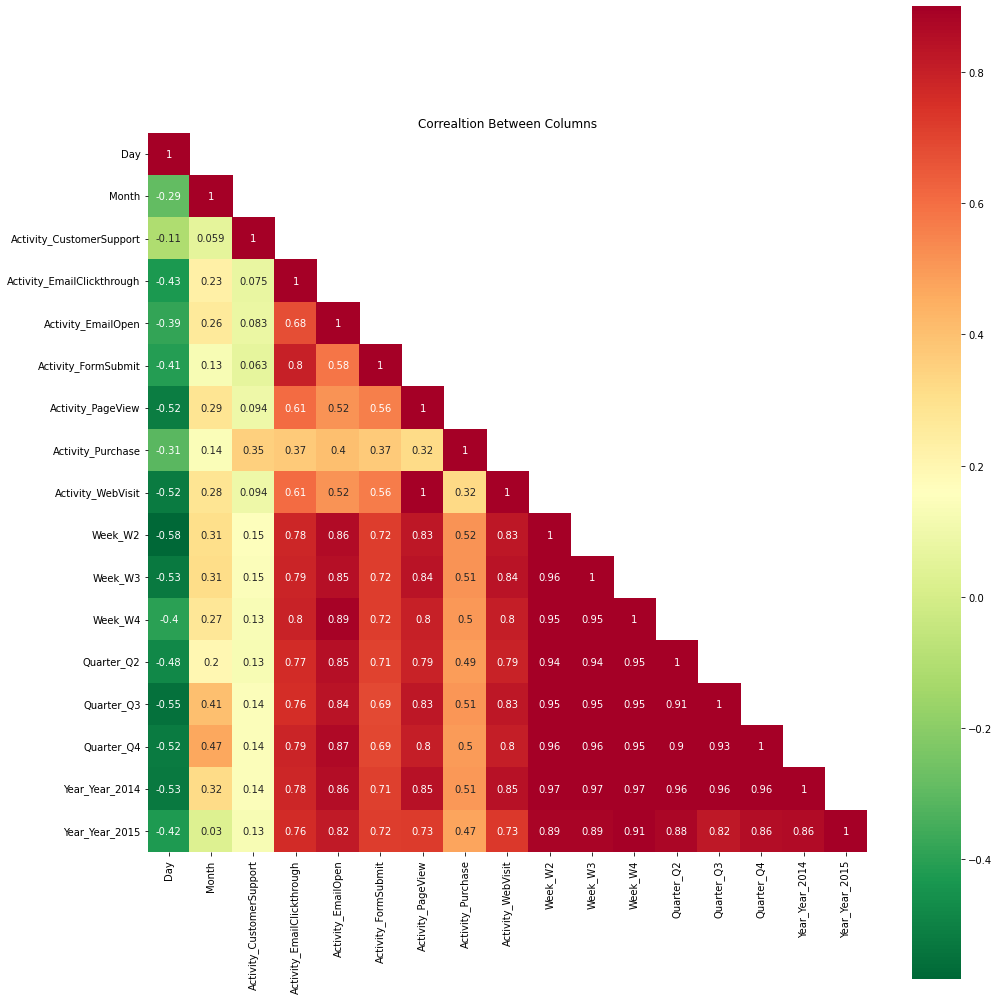

In [193]:
#Firstly, creating the correlation matrix
corr_mat = EDA.corr()
corr_mat_mask = np.array(corr_mat)
#Creating a heatmap
corr_mat_mask[np.tril_indices_from(corr_mat)] = False
plt.figure(figsize=[15,15])
sns.heatmap(corr_mat, mask=corr_mat_mask, vmax=.9,annot=True, square=True, cmap='RdYlGn_r').set(title='Correaltion Between Columns')
plt.tight_layout(2.0)
plt.show()

In [194]:
EDA.columns

Index(['Day', 'Month', 'Activity_CustomerSupport',
       'Activity_EmailClickthrough', 'Activity_EmailOpen',
       'Activity_FormSubmit', 'Activity_PageView', 'Activity_Purchase',
       'Activity_WebVisit', 'Week_W2', 'Week_W3', 'Week_W4', 'Quarter_Q2',
       'Quarter_Q3', 'Quarter_Q4', 'Year_Year_2014', 'Year_Year_2015'],
      dtype='object')

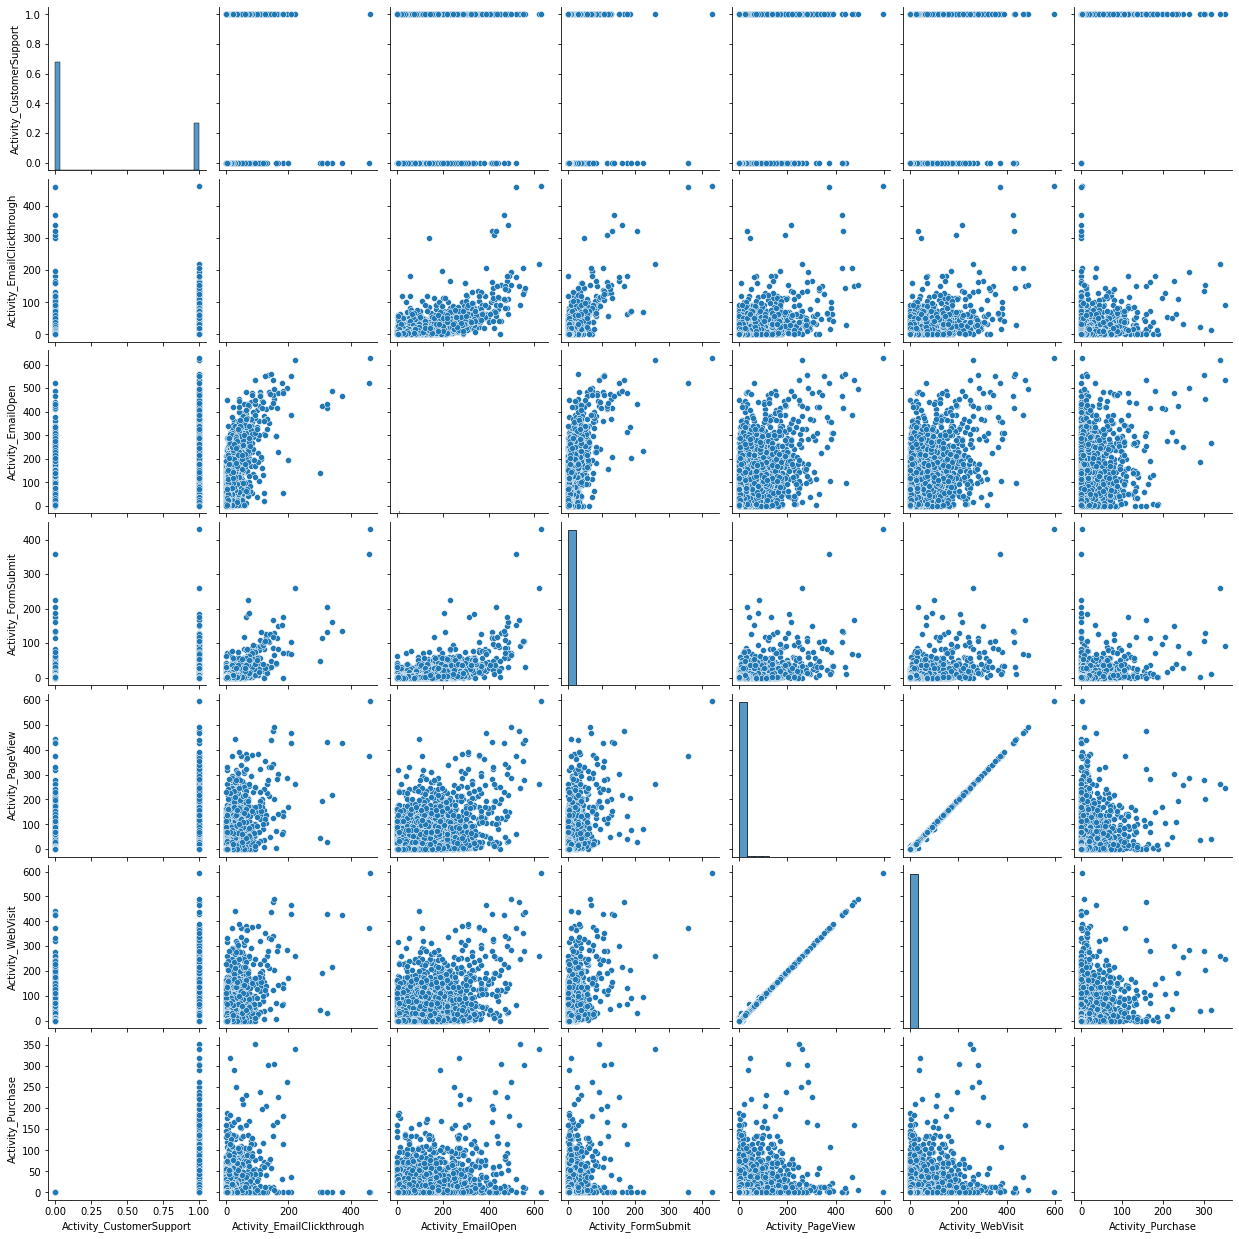

In [197]:
sns.pairplot(EDA[['Activity_CustomerSupport',
       'Activity_EmailClickthrough', 'Activity_EmailOpen',
       'Activity_FormSubmit', 'Activity_PageView',
       'Activity_WebVisit', 'Activity_Purchase']])

### 2.7 Train Valid Split

In [ ]:
# Import required methods
from sklearn.model_selection import train_test_split

# Creating Features and Dependent variable sets
X = df_train.drop(labels='Activity_Purchase',axis=1)
y = df_train['Activity_Purchase']

# Splitting data for training and testing
X_train, X_valid, y_train, y_valid = train_test_split(X , y , test_size=0.3, random_state=21)

In [ ]:
X_train.columns

## 3. Modelling

In [ ]:
from xgboost import XGBClassifier

In [ ]:
model = XGBClassifier(random_state=42, n_jobs=4)
model.fit(X_train, y_train)

In [ ]:
train_preds = model.predict(X_train)
valid_preds = model.predict(X_valid)

## Model Evaluation

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix

In [ ]:
roc_auc_score(train_preds,y_train)

In [ ]:
confusion_matrix(train_preds,y_train)

In [ ]:
confusion_matrix(valid_preds,y_valid)

## Model Testing

In [ ]:
df_test = pd.read_csv('/content/training.tsv',delimiter="\t",header=None)

In [ ]:
df_test.head()

In [ ]:
df_test.columns = ['UID','Date','Activity']

df_UID = df_test['UID']

df_test['Date'] = pd.to_datetime(df_test['Date']) 

df_test['Day'] = df_test['Date'].dt.day
df_test['Month'] = df_test['Date'].dt.month
df_test['Year'] = df_test['Date'].dt.year

#Binning the Age column
cut_labels = ['W1', 'W2', 'W3', 'W4']
cut_bins = [0,7,14,21,31]
df_test['Week'] = pd.cut(df_test['Day'], bins=cut_bins, labels=cut_labels)

#Binning the Age column
cut_labels = ['Q1', 'Q2', 'Q3', 'Q4']
cut_bins = [0,3,6,9,12]
df_test['Quarter'] = pd.cut(df_test['Month'], bins=cut_bins, labels=cut_labels)

df_test['Purchase'] = df_test['Activity'].map({'Purchase':1,'EmailOpen':0,'WebVisit':0,'PageView':0,'EmailClickthrough':0,'FormSubmit':0,'CustomerSupport':0,'CustomerSup':0})

ohe_cols = ['Activity','Week','Quarter']

df_test_ohe  = pd.get_dummies(df_test[ohe_cols],drop_first=True)

df_test_final = pd.concat([df_test,df_test_ohe],axis=1)

df_test_data = df_test_final.drop(labels=cols_drop,axis=1)

In [ ]:
df_test_data.head()

In [ ]:
X = df_test_data.drop(labels='Activity_Purchase',axis=1)
y = df_test_data['Activity_Purchase']

In [ ]:
test_preds = model.predict(X)

In [ ]:
test_preds

In [ ]:
df_test_data.columns

In [ ]:
df_train.columns

In [ ]:
roc_auc_score(test_preds,y)

In [ ]:
confusion_matrix(test_preds,y)

In [ ]:
result = pd.DataFrame({'ID':df_UID,'Purchase':test_preds})

In [ ]:
result.head()

In [ ]:
result['Purchase_Prob'] =-1
result['Purchase_Prob'] = (1-model.predict_proba(X))*100

In [ ]:
result

In [ ]:
top_cust = result.sort_values(by='Purchase_Prob',ascending=False)

In [ ]:
cust = top_cust.groupby(by='ID')['Purchase'].sum().to_frame('Purchase_count')


In [ ]:
output = cust.sort_values(by='Purchase_count',ascending=False)

In [ ]:
op = output.head(1000)
op

In [ ]:
op.to_csv('Top100Customers.csv')

In [ ]:
pd.pivot_table(top_cust, index=['ID'],
                    columns=['Purchase'], aggfunc=np.sum)